# Using Python for Research Homework: Week 3, Case Study 3

In this case study, we will analyze a dataset consisting of an assortment of wines classified as "high quality" and "low quality" and will use k-Nearest Neighbors classification to determine whether or not other information about the wine helps us correctly guess whether a new wine will be of high quality.

In [1]:
# DO NOT EDIT
import numpy as np, random, scipy.stats as ss

def majority_vote_fast(votes):
    mode, count = ss.mstats.mode(votes)
    return mode

def distance(p1, p2):
    return np.sqrt(np.sum(np.power(p2 - p1, 2)))

def find_nearest_neighbors(p, points, k=5):
    distances = np.zeros(points.shape[0])
    for i in range(len(distances)):
        distances[i] = distance(p, points[i])
    ind = np.argsort(distances)
    return ind[:k]

def knn_predict(p, points, outcomes, k=5):
    ind = find_nearest_neighbors(p, points, k)
    return majority_vote_fast(outcomes[ind])[0]

### Exercise 1

Our first step is to import the dataset.

#### Instructions 
- Read in the data as a pandas dataframe using `pd.read_csv`. The data can be found at https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2019+type@asset+block@wine.csv

In [2]:
import pandas as pd

# write your code here!
data = pd.read_csv("./python_case_studies/asset-v1_HarvardX+PH526x+2T2019+type@asset+block@wine.csv", index_col=0)
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  high_quality  
0      9.4        5   red             0  
1      9.8        5   red             0  
2      9.8        5   red             0  
3      9.8        6   red             1  
4      9.4        5   red             0

In [3]:
data.shape

(6497, 14)

### Exercise 2

Next, we will inspect the dataset and perform some mild data cleaning.

#### Instructions 
- In order to get all numeric data, we will change the `color` column to an `is_red` column. 
    - If `color == 'red'`, we will encode a `1` for `is_red`
    - If `color == 'white'`, we will encode a `0` for `is_red`
- Create this new column, `is_red`.
- Drop the `color`, `quality`, and `high_quality` columns as we will be predict the quality of wine using numeric data in a later exercise
- Store this all numeric data in a pandas dataframe called `numeric_data`

In [4]:
# write your code here!
data["is_red"] = (data["color"] == "red").astype(int) 
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  high_quality  is_red  
0      9.4        5   red             0       1  
1      9.8        5   red             0       1  
2      9.8        5   red             0       1  
3      9.8        6   red             1       1  
4      9.4        5   red             0       1

In [5]:
numeric_data = data.drop(["color", "high_quality", "quality"], axis=1)

In [6]:
numeric_data.groupby('is_red').count()

fixed acidity  volatile acidity  citric acid  residual sugar  \
is_red                                                                 
0                4898              4898         4898            4898   
1                1599              1599         1599            1599   

        chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
is_red                                                                        
0            4898                 4898                  4898     4898  4898   
1            1599                 1599                  1599     1599  1599   

        sulphates  alcohol  
is_red                      
0            4898     4898  
1            1599     1599

In [7]:
numeric_data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  is_red  
0      9.4       1  
1      9.8       1  
2      9.8       1  
3      9.8       1  
4      9.4       1

### Exercise 3

We want to ensure that each variable contributes equally to the kNN classifier, so we will need to scale the data by subtracting the mean of each variable (column) and dividing each variable (column) by its standard deviation. Then, we will use principal components to take a linear snapshot of the data from several different angles, with each snapshot ordered by how well it aligns with variation in the data. In this exercise, we will scale the numeric data and extract the first two principal components.

#### Instructions 
- Scale the data using the `sklearn.preprocessing` function `scale()` on `numeric_data`.
- Convert this to a `pandas` dataframe, and store as `numeric_data`.
    - Include the numeric variable names using the parameter `columns = numeric_data.columns`.
- Use the `sklearn.decomposition` module `PCA()` and store it as `pca`.
- Use the `fit_transform()` function to extract the first two principal components from the data, and store them as `principal_components`.
- *Note*: You may get a `DataConversionWarning`, but you can safely ignore it

In [8]:
import sklearn.preprocessing
scaled_data = sklearn.preprocessing.scale(numeric_data)
scaled_data

array([[ 0.14247327,  2.18883292, -2.19283252, ...,  0.19309677,
        -0.91546416,  1.75018984],
       [ 0.45103572,  3.28223494, -2.19283252, ...,  0.99957862,
        -0.58006813,  1.75018984],
       [ 0.45103572,  2.55330026, -1.91755268, ...,  0.79795816,
        -0.58006813,  1.75018984],
       ...,
       [-0.55179227, -0.6054167 , -0.88525328, ..., -0.47897144,
        -0.91546416, -0.57136659],
       [-1.32319841, -0.30169391, -0.12823371, ..., -1.016626  ,
         1.9354021 , -0.57136659],
       [-0.93749534, -0.78765037,  0.42232597, ..., -1.41986693,
         1.09691202, -0.57136659]])

In [9]:
numeric_data = pd.DataFrame(scaled_data, columns=numeric_data.columns)
numeric_data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.142473          2.188833    -2.192833       -0.744778   0.569958   
1       0.451036          3.282235    -2.192833       -0.597640   1.197975   
2       0.451036          2.553300    -1.917553       -0.660699   1.026697   
3       3.073817         -0.362438     1.661085       -0.744778   0.541412   
4       0.142473          2.188833    -2.192833       -0.744778   0.569958   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -1.100140             -1.446359  1.034993  1.813090   0.193097   
1            -0.311320             -0.862469  0.701486 -0.115073   0.999579   
2            -0.874763             -1.092486  0.768188  0.258120   0.797958   
3            -0.762074             -0.986324  1.101694 -0.363868   0.327510   
4            -1.100140             -1.446359  1.034993  1.813090   0.193097   

    alcohol   is_red  
0 -0.915464  1.75019  
1 -0.580068  1.75019  
2 -0.580068  1.75019  
3 -0.580068  1.75019  
4 -0.915464  1.75019

In [10]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=2) 
pca

PCA(n_components=2)

In [11]:
principal_components = pca.fit_transform(numeric_data)
principal_components 

array([[ 3.73606125, -0.14116701],
       [ 3.68227354,  0.56082363],
       [ 3.66368602,  0.32778184],
       ...,
       [-0.90178164, -0.62769604],
       [-0.9152328 , -3.4741706 ],
       [-1.19228932, -2.75002049]])

In [12]:
principal_components.shape

(6497, 2)

### Exercise 4

In this exercise, we will plot the first two principal components of the covariates in the dataset. The high and low quality wines will be colored using red and blue, respectively.

#### Instructions 
- The first two principal components can be accessed using `principal_components[:,0]` and `principal_components[:,1]`. Store these as `x` and `y` respectively, and make a scatter plot of these first two principal components.
- How well are the two groups of wines separated by the first two principal components?

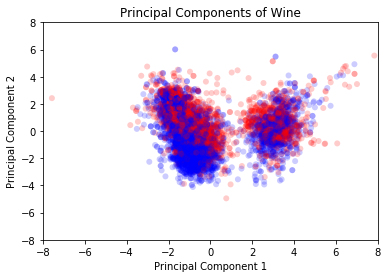

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages
observation_colormap = ListedColormap(['red', 'blue'])
x = principal_components[:,0]
y = principal_components[:,1]

plt.title("Principal Components of Wine")
plt.scatter(x, y, alpha = 0.2,
    c = data['high_quality'], cmap = observation_colormap, edgecolors = 'none')
plt.xlim(-8, 8); plt.ylim(-8, 8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### Exercise 5

In this exercise, we will create a function that calculates the accuracy between predictions and outcomes.

#### Instructions
- Create a function `accuracy(predictions, outcomes)` that takes two lists of the same size as arguments and returns a single number, which is the percentage of elements that are equal for the two lists.
- Use accuracy to compare the percentage of similar elements in the `x` and `y` `numpy` arrays defined below.
- Print your answer.

In [14]:
import numpy as np 
np.random.seed(1) # do not change

x = np.random.randint(0, 2, 1000)
y = np.random.randint(0 ,2, 1000)

def accuracy(predictions, outcomes):
    # write your code here!
    

SyntaxError: unexpected EOF while parsing (<ipython-input-14-0a0032aa5914>, line 9)

### Exercise 6

The dataset remains stored as data. Because most wines in the dataset are classified as low quality, one very simple classification rule is to predict that all wines are of low quality. In this exercise, we determine the accuracy of this simple rule. 

#### Instructions
- Use `accuracy()` to calculate how many wines in the dataset are of low quality. Do this by using 0 as the first argument, and `data["high_quality"]` as the second argument.
- Print your result.

In [ ]:
# write your code here!


### Exercise 7 

In this exercise, we will use the kNN classifier from `scikit-learn` to predict the quality of wines in our dataset.

#### Instructions
- Use `knn.predict(numeric_data)` to predict which wines are high and low quality and store the result as `library_predictions`.
- Use `accuracy` to find the accuracy of your predictions, using `library_predictions` as the first argument and `data["high_quality"]` as the second argument.
- Print your answer. Is this prediction better than the simple classifier in Exercise 6?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(numeric_data, data['high_quality'])
# Enter your code here!


### Exercise 8

Unlike the `scikit-learn` function, our homemade kNN classifier does not take any shortcuts in calculating which neighbors are closest to each observation, so it is likely too slow to carry out on the whole dataset. In this exercise, we will select a subset of our data to use in our homemade kNN classifier.

#### Instructions 
- Fix the random generator using `random.seed(123)`, and select 10 rows from the dataset using `random.sample(range(n_rows), 10)`. Store this selection as `selection`.

In [ ]:
n_rows = data.shape[0]
# Enter your code here.


### Exercise 9

We are now ready to use our homemade kNN classifier and compare the accuracy of our results to the baseline.

#### Instructions 
- For each predictor` p` in `predictors[selection]`, use `knn_predict(p, predictors[training_indices,:], outcomes[training_indices], k=5)` to predict the quality of each wine in the prediction set, and store these predictions as a np.array called `my_predictions`. Note that knn_predict is already defined as in the Case 3 videos.
- Using the `accuracy` function, compare these results to the selected rows from the `high_quality` variable in data using `my_predictions` as the first argument and `data.high_quality.iloc[selection]` as the second argument. Store these results as `percentage`.
- Print your answer.

In [ ]:
predictors = np.array(numeric_data)
training_indices = [i for i in range(len(predictors)) if i not in selection]
outcomes = np.array(data["high_quality"])

my_predictions = # Enter your code here!
percentage = # Enter your code here!